In [24]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os.path
import sys
import array
import time
import serial

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def setVol(ser,voltage):
    """
    input: 
        n:the modulation voltage in Volte
    output: 
        the modulation voltage after re-setting
    set the modulation voltage to n and return voltage at present
    """
    st='SLVL'+str(voltage)+'\n'
    ser.write(str.encode(st))
    ser.write(str.encode('SLVL?\n')) #return the modulation voltage after re-setting
    s = float(ser.readline());
    return ('voltage is '+str(s))

def cmdser(ser,cmd):
    """
    input:
        ser: your serial
        cmd: strings of command
            '*IDN?'= Queries the device identification
            'OUTP?1' = Queries the value of X (CH1)
            for other command, refer: http://users.df.uba.ar/dgrosz/material%20adicional/manual%20lock-in%20SR830.pdf from page 85.
    output:
        natural return
    giving command to SR830
    """
#     print('Sending:', cmd)
    ser.write(str.encode(cmd+'\n'))#read output in channel 1
    s = ser.readline();
    if len(s) > 0:
        print(s)
    return(s)

def cmd(ser,cmd):
    ser.write(str.encode(cmd+'\n'))#read output in channel 1
    s = ser.readline();
    return(s)


def decodeSens(n):
    """turn ['1','10**(-9)] into the number"""
    d1 = [1, 2, 5, 10, 20, 50, 100, 200, 500]
    d2 = [10**(-9),10**(-6),10**(-3),1]
    n = int(n)
    x=(n+1)%9
    y=int((n+1)/9)
#     print(x,y)
    sens = d1[x]*d2[y]
    return sens

def returnSens(ser):
    return(decodeSens(cmd(ser,'SENS?')))
    
SENSLIST=[2e-09, 5e-09, 1e-08, 2e-08, 5e-08, 1e-07, 2e-07, 5e-07, 1e-06, 2e-06, 5e-06, 1e-05, 2e-05, 5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
TIMECONSTLIST=[1e-05, 3e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]

In [112]:
def plot2pic():
#     global fig,ax1,ax2,o1,ser,s
    s=ser.readline()
    while(len(s)>0):
        s=ser.readline()
    time.sleep(0.2)
    while(True):
        try:
            ser.write(b'SENS?\n')
            a3=int(ser.readline());
            ser.write(b'OUTP?1\n')
            a1=float(ser.readline());
            ser.write(b'OUTP?2\n')
            a2=float(ser.readline());
            s = SENSLIST[a3]
            f1 = a1/s
            f2 = a2/s
            if(f1>1):f1=0.98
            if(f1<-1):f1=-0.98
            if(f2>1):f2=0.98
            if(f2<-1):f2=-0.98
            o1.append(f1*20)
            o2.append(f2*20)
            ax1.set_title("Lockin X:%.3f"%(f1*20))
            ax2.set_title("Lockin Y:%.3f"%(f2*20))
            ax1.set_ylabel("bars")
            ax1.set_xlabel("time")
            ax2.set_ylabel("bars")
            ax2.set_xlabel("time")
    #         plt.text(0,19,'sens:%3s'%(s),fontsize=15)
#             ax1.text(0.95, 0.01, 'sens:%.3s'%(s),verticalalignment='bottom', horizontalalignment='right',
#             transform=ax1.transAxes,fontsize=15)
            ax1.plot(o1)
            ax2.plot(o2)
            fig.canvas.draw()
            
        except KeyboardInterrupt:
            ser.readline()
            break
        

def sensUp(none):
#     ser.readline()
    ser.write(b'SENS?\n')
    x = int(ser.readline())
    x = str(x+1)
    ser.write(str.encode('SENS'+x+'\n'))
    ser.write(b'SENS?\n')
    x = int(ser.readline());
    op = SENSLIST[x]
    print("\r"+"SENS="+str(op),end="         ");

def sensDown(_):
#     ser.readline()
    ser.write(b'SENS?\n')
    x = int(ser.readline())
    x = str(x-1)
    ser.write(str.encode('SENS'+x+'\n'))
    ser.write(b'SENS?\n')
    x = int(ser.readline());
    op = SENSLIST[x]
    print("\r"+"SENS="+str(op),end="         ");

def timeUp(_):
#     ser.readline()
    ser.write(b'OFLT?\n')
    x = int(ser.readline())
    x = str(x+1)
    ser.write(str.encode('OFLT'+x+'\n'))
    ser.write(b'OFLT?\n')
    x = int(ser.readline());
    op = TIMECONSTLIST[x]
    print("\r"+"TimeConst="+str(op),end="       ");

def timeDown(_):
#     ser.readline()
    ser.write(b'OFLT?\n')
    x = int(ser.readline())
    x = str(x-1)
    ser.write(str.encode('OFLT'+x+'\n'))
    ser.write(b'OFLT?\n')
    x = int(ser.readline());
    op = TIMECONSTLIST[x]
    print("\r"+"TimeConst="+str(op),end="       ");

def generatePanal():
    ser.readline() # buffer
    suButton = widgets.Button(description='sens Up')
    sdButton = widgets.Button(description='sens Down')
    tuButton = widgets.Button(description='time Up')
    tdButton = widgets.Button(description='time Down')
    display(suButton)
    display(sdButton)
    display(tuButton)
    display(tdButton)
        
    suButton.on_click(sensUp)
    sdButton.on_click(sensDown)
    tuButton.on_click(timeUp)
    tdButton.on_click(timeDown)

def volMax1():
    interact(setVol,ser=fixed(ser),voltage=widgets.FloatSlider(min=0.0000, max=1.00, step=0.0001,readout_format='.3f'));
def volMax5():
    interact(setVol,ser=fixed(ser),voltage=widgets.FloatSlider(min=0.0000, max=1.00, step=0.0001,readout_format='.3f'));

In [113]:
import serial.tools.list_ports

ports = serial.tools.list_ports.comports() #Normally choose the last one
for p in ports:
    print(p.device)
print(len(ports), 'ports found')

/dev/cu.Bluetooth-Incoming-Port
/dev/cu.ZebraMachine-SPPDev
/dev/cu.usbserial-PX4IHXWN
3 ports found


# Initialize
* Each port could only be opened once, then it needs to be closed untill be assigend to next serial. 
* therefore 「ser = ...」could be run once. after that it will cause error. but as long as second block 「cmdser」 is working well is fine.
* If the port was not closed properly last time, you can go to device manager and reasign a port. 
* The best plan is to not quit jupyter notebook.

In [114]:
import serial, sys
port = 'COM2'
baudrate = 9600
ser = serial.Serial(port,baudrate,timeout=1)

In [115]:
cmdser(ser,'SLVL?');
cmdser(ser,'SENS?');
cmdser(ser,'OFLT?');

b'0.058\n'
b'21\n'
b'4\n'


## change Amplitude, Sensitivity and Time constant here
notice that both sensitivity and time constant has maximum and minimum.

if any error occors, just rerun the cell

In [116]:
volMax1()
# volMax5() # if you want to chagne to higher than 1V, use this line
generatePanal() 

interactive(children=(FloatSlider(value=0.0, description='voltage', max=1.0, readout_format='.3f', step=0.0001…

Button(description='sens Up', style=ButtonStyle())

Button(description='sens Down', style=ButtonStyle())

Button(description='time Up', style=ButtonStyle())

Button(description='time Down', style=ButtonStyle())

Before changing the sensitivity and time constant: 
   1. Use esc to change to command line mode
   2. Hit i twice to quit, wait untill In[*] change to In[number].(or you can hit interupt kernal in menu)
   3. After changing, rerun this cell
  

<IPython.core.display.Javascript object>


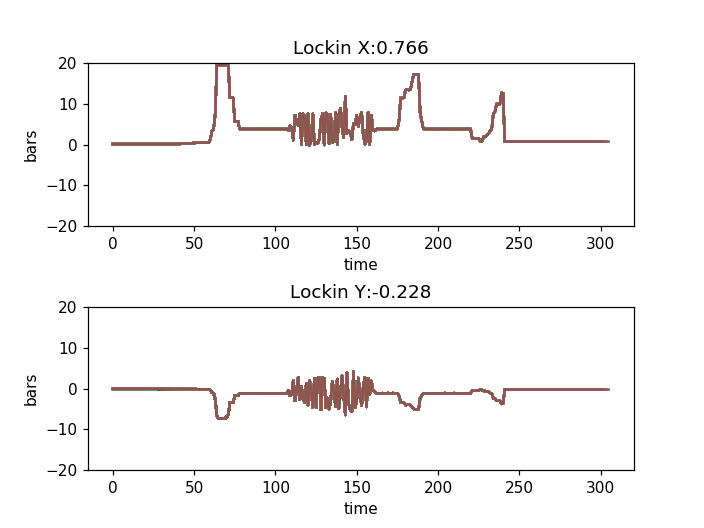

In [121]:
o1=[]
o2=[]

fig,(ax1,ax2)=plt.subplots(2,1)
ax1.set_ylim(-20,20)
ax2.set_ylim(-20,20)
fig.subplots_adjust(hspace=.5)

plot2pic() # plot Lockin

# Before quit jupyter, close port. (better not to quit jupyter)

In [123]:
ser.close()